In [ ]:
!gzip -d data/*

gzip: data/t10k-images-idx3-ubyte: unknown suffix -- ignored
gzip: data/t10k-labels-idx1-ubyte: unknown suffix -- ignored
gzip: data/train-images-idx3-ubyte: unknown suffix -- ignored
gzip: data/train-labels-idx1-ubyte: unknown suffix -- ignored


In [1]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt

mndata = MNIST('data')

images, labels = mndata.load_training()
images = images[:1000]
labels = labels[:1000]
print (f"image length is: {len(images)}")

image length is: 1000


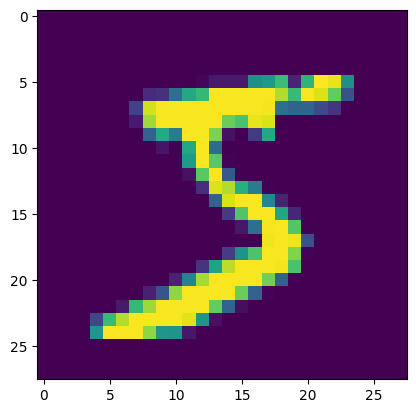

In [2]:
import matplotlib.pyplot as plt

plt.imshow(np.array(images[0]).reshape(28, 28))

# Models Correlated by data

## SVM model

### Training the model

In [3]:
from sklearn import svm
kernel_Svm=svm.SVC(probability=True)
kernel_Svm.fit(images, labels)

SVC(probability=True)

In [4]:
test_images, test_labels = mndata.load_testing()
y_prob = kernel_Svm.predict_proba(test_images)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.90      0.91      0.91      1032
           3       0.94      0.85      0.89      1010
           4       0.89      0.90      0.89       982
           5       0.84      0.89      0.87       892
           6       0.94      0.92      0.93       958
           7       0.94      0.90      0.92      1028
           8       0.88      0.87      0.88       974
           9       0.85      0.91      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



<AxesSubplot: >

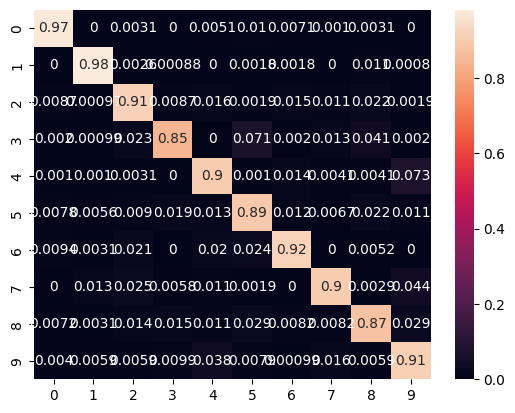

In [5]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print (classification_report(np.array(test_labels), np.argmax(y_prob, axis=1)))
sns.heatmap(confusion_matrix(np.array(test_labels), np.argmax(y_prob, axis=1), normalize="true"),annot=True)

### Calculating the estimated calibration error

In [6]:
test_images, test_labels = mndata.load_testing()
y_prob_svm = kernel_Svm.predict_proba(test_images)

In [7]:
def classwise_ece(y_true, y_prob, n_bins=10):
    n_classes = y_true.shape[1]
    ece = 0.0
    for c in range(n_classes):
        y_class = y_true[:, c]
        y_prob_class = y_prob[:, c]
        bins = np.linspace(0, 1, n_bins + 1)
        bin_indices = np.digitize(y_prob_class, bins) - 1
        bin_sizes = np.bincount(bin_indices, minlength=n_bins)
        bin_probs = np.bincount(bin_indices, weights=y_prob_class, minlength=n_bins) / (bin_sizes + 1e-10)
        bin_accuracies = np.bincount(bin_indices, weights=y_class, minlength=n_bins) / (bin_sizes + 1e-10)
        ece_class = np.abs(bin_accuracies - bin_probs).dot(bin_sizes / y_class.shape[0])
        ece += ece_class
    ece /= n_classes
    return ece

In [8]:
ece_value = classwise_ece(np.eye(10)[test_labels], y_prob)
print("Expected Calibration Error:", ece_value)

Expected Calibration Error: 0.018022812288535316


## Training a deep neural network

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf


def build_model(input_shape, activation, n_hiddenlayers, hidden_dim):
    input = Input(shape=(input_shape,))
    for i in range(n_hiddenlayers):
      if i == 0:
        x = Dense(hidden_dim, activation=activation)(input)
      else :
        x = Dense(hidden_dim, activation=activation)(x)
        x = Dropout(rate=0.2)(x)

      output = Dense(10, activation='softmax')(x)
      model = Model(input, output, name='first_model')
    return model

In [28]:
# Build a network with 10 hidden layers with 'tanh' activations
n_hiddenlayers = 10
activation = 'relu'
hidden_dim = 256
model = build_model(np.array(images).shape[1], activation, n_hiddenlayers, hidden_dim)

# Print the model
model.summary()

Model: "first_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_90 (Dense)            (None, 256)               200960    
                                                                 
 dense_92 (Dense)            (None, 256)               65792     
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_94 (Dense)            (None, 256)               65792     
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_96 (Dense)            (None, 256)               

In [30]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.1, 
            random_state=56)

es = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=20)
callbacks_list = [es]

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(np.array(train_images), np.array(train_labels),validation_data=(val_images, val_labels),
                    epochs=100, batch_size=250, callbacks=callbacks_list, verbose=1)

Epoch 1/100
4/4 [==============================] - 1s 166ms/step - loss: 2.2695 - accuracy: 0.1456 - val_loss: 2.1588 - val_accuracy: 0.3900
Epoch 2/100
4/4 [==============================] - 0s 50ms/step - loss: 2.2194 - accuracy: 0.1611 - val_loss: 2.0090 - val_accuracy: 0.4100
Epoch 3/100
4/4 [==============================] - 0s 51ms/step - loss: 2.1261 - accuracy: 0.2000 - val_loss: 1.8598 - val_accuracy: 0.4100
Epoch 4/100
4/4 [==============================] - 0s 43ms/step - loss: 2.0322 - accuracy: 0.2400 - val_loss: 1.7259 - val_accuracy: 0.4200
Epoch 5/100
4/4 [==============================] - 0s 50ms/step - loss: 1.8927 - accuracy: 0.2844 - val_loss: 1.5266 - val_accuracy: 0.4500
Epoch 6/100
4/4 [==============================] - 0s 51ms/step - loss: 1.7754 - accuracy: 0.3211 - val_loss: 1.3292 - val_accuracy: 0.4800
Epoch 7/100
4/4 [==============================] - 0s 44ms/step - loss: 1.5890 - accuracy: 0.3956 - val_loss: 1.2161 - val_accuracy: 0.5500
Epoch 8/100
4/4 [==

In [15]:
test_images, test_labels = mndata.load_testing()
y_prob_dnn = model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


In [16]:
ece_value = classwise_ece(np.eye(10)[test_labels], y_prob)
print("Expected Calibration Error:", ece_value)

Expected Calibration Error: 0.018022812288535316


### Calculating the Pearson correlation coefficient

In [17]:
from scipy.stats import pearsonr

def pearson_correlation(y_pred_prob1, y_pred_prob2):
    n_classes = y_pred_prob1.shape[1]
    corrs = np.zeros(n_classes)
    for class_idx in range(n_classes):
        corrs[class_idx], _ = pearsonr(y_pred_prob1[:, class_idx], y_pred_prob2[:, class_idx])
    return corrs

In [18]:
print(np.mean(pearson_correlation(y_prob_svm, y_prob_dnn)))

0.8715367126627015


Studying the correlation/confidence relationship

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e76c8840-118e-4c48-bc4e-42f2efb5350a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>